<a href="https://colab.research.google.com/github/tmaiecnj/CPE-313/blob/main/Hands-on%20Activity%207.1%20-%20Deep%20Learning%20in%20Time%20Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Github Link: [Hands-on Activity 7.1: Deep Learning in Time Series](https://github.com/tmaiecnj/CPE-313/blob/main/Hands-on%20Activity%207.1%20-%20Deep%20Learning%20in%20Time%20Series.ipynb)

# Activity 4.4 Deep Learning in Time Series

## Objective(s):
This activity aims to introduce how to build and train a simple RNN or LSTM for time series forecasting, using Keras.

## Intended Learning Outcomes (ILOs):
* Demonstrate how to build and train RNN for time series forecasting
* Demonstrate how to build and train LSTM for time series forecasting

## Resources:
* Jupyter Notebook
* Beijing.csv

## Procedures

Load the necessary libraries

In [12]:
%matplotlib inline

import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd

import keras
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, Dropout
from keras.optimizers import SGD

Build a recurrent neural network and train it to forecast a single time series.
* Load and setup the dataset

In [13]:
file_path = "/content/drive/MyDrive/Dataset/Time Series/Beijing-1.csv"

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
df_Beijing = pd.read_csv(file_path)
df_Beijing = df_Beijing[df_Beijing.year >= 2015]
df_Beijing.head(10)

,No,year,month,day,hour,season,PM_Dongsi,PM_Dongsihuan,PM_Nongzhanguan,PM_US Post,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation,Iprec
43824,43825,2015,1,1,0,4,5.0,32.0,8.0,22.0,-21.0,29.0,1034.0,-6.0,SE,0.89,0.0,0.0
43825,43826,2015,1,1,1,4,4.0,12.0,7.0,9.0,-22.0,23.0,1034.0,-4.0,NW,4.92,0.0,0.0
43826,43827,2015,1,1,2,4,3.0,19.0,7.0,9.0,-21.0,27.0,1034.0,-5.0,NW,8.94,0.0,0.0
43827,43828,2015,1,1,3,4,4.0,9.0,11.0,13.0,-21.0,29.0,1035.0,-6.0,NW,12.96,0.0,0.0
43828,43829,2015,1,1,4,4,3.0,11.0,5.0,10.0,-21.0,27.0,1034.0,-5.0,NW,16.98,0.0,0.0
43829,43830,2015,1,1,5,4,3.0,18.0,3.0,6.0,-22.0,23.0,1034.0,-4.0,NW,24.13,0.0,0.0
43830,43831,2015,1,1,6,4,3.0,20.0,6.0,8.0,-23.0,22.0,1034.0,-5.0,NW,25.92,0.0,0.0
43831,43832,2015,1,1,7,4,3.0,22.0,7.0,17.0,-22.0,26.0,1035.0,-6.0,SE,1.79,0.0,0.0
43832,43833,2015,1,1,8,4,NaN,NaN,NaN,11.0,-22.0,29.0,1035.0,-7.0,cv,0.89,0.0,0.0
43833,43834,2015,1,1,9,4,5.0,37.0,11.0,33.0,-22.0,24.0,1035.0,-5.0,NE,1.79,0.0,0.0


Forecast the 'PM' series, which are measurements of air pollution for several different districts. Note that there are occasional missing values in these series, which we can fill with simple linear interpolation. To start, we'll focus on the "PM_Dongsi" series and interpolate the missing values.

In [16]:
df_Beijing['PM_Dongsi'] = df_Beijing['PM_Dongsi'].interpolate()
df_Beijing['PM_Dongsi'].head(10)

43824    5.0
43825    4.0
43826    3.0
43827    4.0
43828    3.0
43829    3.0
43830    3.0
43831    3.0
43832    4.0
43833    5.0
Name: PM_Dongsi, dtype: float64

Create a function to extract and plot the last *n* days of data

In [17]:
def get_n_last_days(df, series_name, n_days):
  """
  Extract last n_days of an hourly time series
  """
  return df[series_name][-(24*n_days):]

In [18]:
def plot_n_last_days(df, series_name, n_days):
  """
  Plot last n_days of an hourly time series
  """
  plt.plot(get_n_last_days(df, series_name, n_days), 'k-')
  plt.title('{0} Air Quality Time Series - {1} days'.format(series_name, n_days))

  plt.xlabel('Recorded Hour')
  plt.ylabel('Reading')
  plt.grid(alpha=0.3)

Check last 6 weeks of data look like

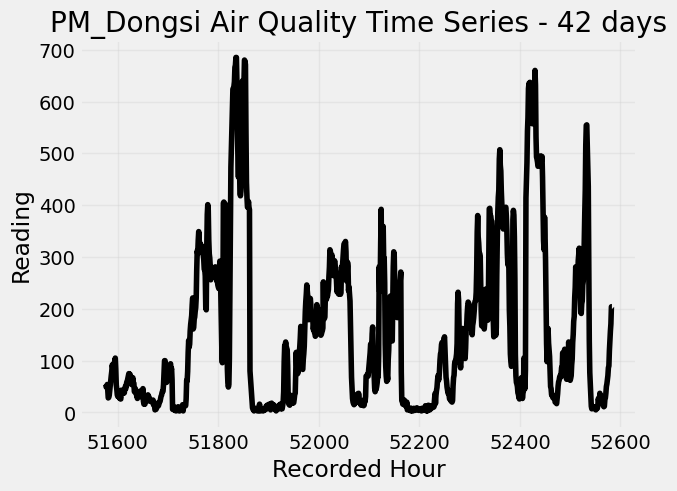

In [19]:
plot_n_last_days(df_Beijing, 'PM_Dongsi', 42)

Train a simple RNN to forecast the PM_Dongsi time series

In [20]:
def get_keras_format_series(series):
  """
  Convert a series to a numpy array of shape
  [n_samples, time_steps, features]
  """

  series = np.array(series)
  return series.reshape(series.shape[0], series.shape[1], 1)

In [21]:
def get_train_test_data(df, series_name, series_days, input_hours, test_hours, sample_gap=3):
  """
  Utility processing function that splits an hourly time series into
  train and test with keras-friendly format, according to user-specified
  choice of shape.

  arguments
  ---------
  df (dataframe): dataframe with time series columns
  series_name (string): column name in df
  series_days (int): total days to extract
  input_hours (int): length of sequence input to network
  test_hours (int): length of held-out terminal sequence
  sample_gap (int): step size between start of train sequences; default 5

  returns
  ---------
  tuple: train_X, test_X_init, train_y, test_y
  """

  forecast_series = get_n_last_days(df, series_name, series_days).values

  train = forecast_series[:-test_hours]
  test = forecast_series[-test_hours:]

  train_X, train_y = [], []

  for i in range(0, train.shape[0]-input_hours, sample_gap):
    train_X.append(train[i:i+input_hours])
    train_y.append(train[i+input_hours])

  train_X = get_keras_format_series(train_X)
  train_y = np.array(train_y)

  test_X_init = test[:input_hours]
  test_y = test[input_hours:]

  return train_X, test_X_init, train_y, test_y

With the get_train_test_data utility function in hand, we're all set to extract keras-friendly arrays and
start training simple RNN models. We run this function in the cell below. We use the last 56 days of
the PM_Dongsi series, and will train a model that takes in 12 time steps in order to predict the next
time step. We use the last day of data for visually testing the model.

In [22]:
series_days = 56
input_hours = 12
test_hours = 24

In [23]:
train_X, test_X_init, train_y, test_y = (get_train_test_data(df_Beijing,
                                                             'PM_Dongsi',
                                                             series_days,
                                                             input_hours,
                                                             test_hours))

Below we see that by taking multiple time slices, we get 436 training samples of 12 time steps each.

In [24]:
print('Training shape: {}'.format(train_X.shape))

Training shape: (436, 12, 1)


Train a simple RNN model using keras.

In [25]:
def fit_SimpleRNN(train_X, train_y, cell_units, epochs):
  """
  Fit Simple RNN to data train_X, train_y

  arguments
  ---------
  train_X (array): input sequence samples for training
  train_y (list): next step in sequence targets
  cell_units (int): number of hidden units for RNN cells
  epochs (int): number of training epochs
  """

  # initialize model
  model = Sequential()

  # construct an RNN layer with specified number of hidden units
  # per cell and desired sequence input format
  model.add(SimpleRNN(cell_units, input_shape=(train_X.shape[1],1)))

  # add an output layer to make final predictions
  model.add(Dense(1))

  # define the loss function / optimization strategy, and fit
  # the model with the desired number of passes over the data (epochs)
  model.compile(loss='mean_squared_error', optimizer='adam')
  model.fit(train_X, train_y, epochs=epochs, batch_size=64, verbose=0)

  return model

Use this function to fit a very simple baseline model.

In [26]:
model = fit_SimpleRNN(train_X, train_y, cell_units=10, epochs=10)

This prediction method and a utility function for plotting its output against the ground truth are
defined below.

In [27]:
def predict(X_init, n_steps, model):
  """
  Given an input series matching the model's expected format,
  generates model's predictions for next n_steps in the series
  """

  X_init = X_init.copy().reshape(1,-1,1)
  preds = []

  # iteratively take current input sequence, generate next step pred,
  # and shift input sequence forward by a step (to end with latest pred).
  # collect preds as we go.
  for _ in range(n_steps):
    pred = model.predict(X_init)
    preds.append(pred)
    X_init[:,:-1,:] = X_init[:,1:,:]
    X_init[:,-1,:] = pred

  preds = np.array(preds).reshape(-1,1)
  return preds

In [28]:
def predict_and_plot(X_init, y, model, title):
  """
  Given an input series matching the model's expected format,
  generates model's predictions for next n_steps in the series,
  and plots these predictions against the ground truth for those steps

  arguments
  ---------
  X_init (array): initial sequence, must match model's input shape
  y (array): true sequence values to predict, follow X_init
  model (keras.models.Sequential): trained neural network
  title (string): plot title
  """

  y_preds = predict(test_X_init, n_steps=len(y), model=model)

  start_range = range(1, input_hours+1)
  predict_range = range(input_hours, test_hours)

  plt.plot(start_range, test_X_init)
  plt.plot(predict_range, test_y, color='orange')
  plt.plot(predict_range, y_preds, color='teal', linestyle='--')

  plt.title(title)
  plt.legend(['Initial Series','Target Series','Predictions'])

1/1 [==============================] - 0s 23ms/step


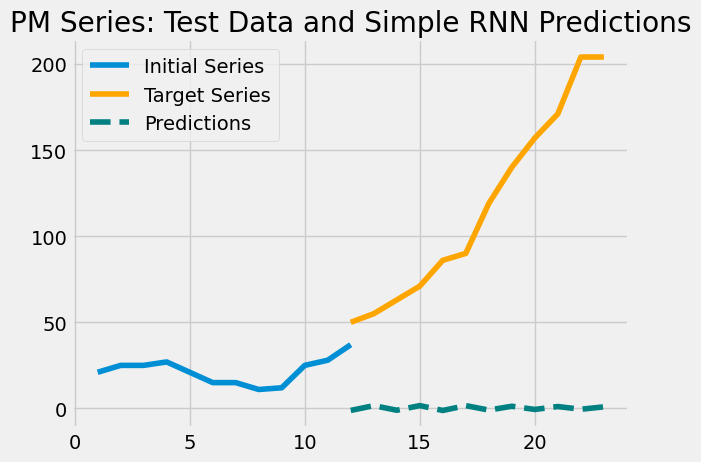

In [29]:
predict_and_plot(test_X_init,
                 test_y, model,
                 'PM Series: Test Data and Simple RNN Predictions')

Retrain the model a few times in order to get results that we're happy with.

In [30]:
model = fit_SimpleRNN(train_X, train_y, cell_units=30, epochs=1200)

1/1 [==============================] - 0s 21ms/step


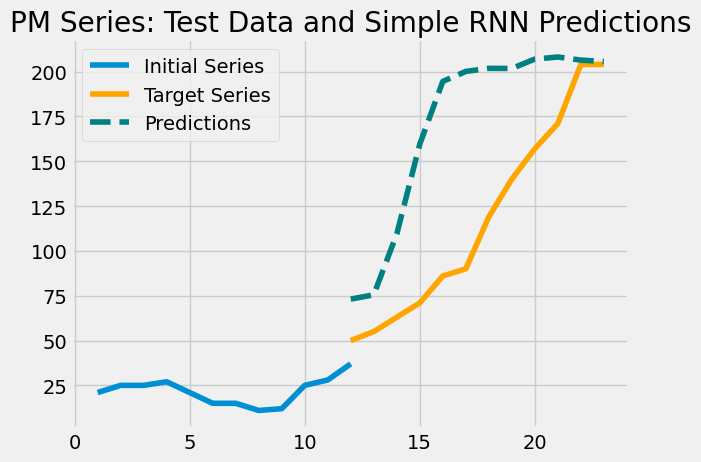

In [31]:
predict_and_plot(test_X_init,
                 test_y, model,
                 'PM Series: Test Data and Simple RNN Predictions')

In [32]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 30)                960       
                                                                 
 dense_1 (Dense)             (None, 1)                 31        
                                                                 
Total params: 991 (3.87 KB)
Trainable params: 991 (3.87 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### LSTM

Write a new function for fitting an LSTM with keras

In [33]:
def fit_LSTM(train_X, train_y, cell_units, epochs):
  """
  Fit LSTM to data train_X, train_y

  arguments
  ---------
  train_X (array): input sequence samples for training
  train_y (list): next step in sequence targets
  cell_units (int): number of hidden units for LSTM cells
  epochs (int): number of training epochs
  """

  # initialize model
  model = Sequential()

  # construct a LSTM layer with specified number of hidden units
  # per cell and desired sequence input format
  model.add(LSTM(cell_units, input_shape=(train_X.shape[1],1)))

  # add an output layer to make final predictions
  model.add(Dense(1))

  # define the loss function / optimization strategy, and fit
  # the model with the desired number of passes over the data (epochs)
  model.compile(loss='mean_squared_error', optimizer='adam')
  model.fit(train_X, train_y, epochs=epochs, batch_size=64, verbose=0)

  return model

Train a LSTM to forecast the PM_Nongzhanguan time series

In [34]:
series_days = 50
input_hours = 12
test_hours = 96

In [35]:
train_X, test_X_init, train_y, test_y = (get_train_test_data(df_Beijing,
                                                             'PM_Nongzhanguan',
                                                             series_days,
                                                             input_hours,
                                                             test_hours))

In [36]:
model = fit_LSTM(train_X, train_y, cell_units=70, epochs=3000)

1/1 [==============================] - 0s 24ms/step


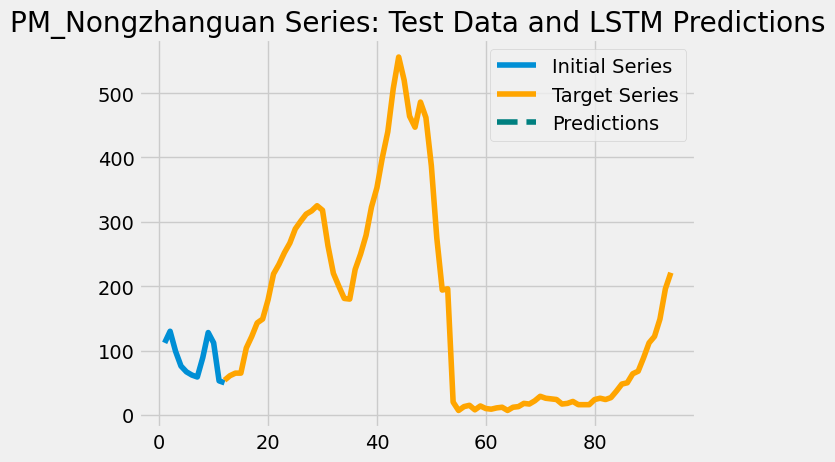

In [37]:
predict_and_plot(test_X_init,
                 test_y, model,
                 'PM_Nongzhanguan Series: Test Data and LSTM Predictions')

In [38]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 70)                20160     
                                                                 
 dense_2 (Dense)             (None, 1)                 71        
                                                                 
Total params: 20231 (79.03 KB)
Trainable params: 20231 (79.03 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Supplementary Activity

* Train your own model to forecast the "PM_Nongzhaguan" series from the Beijing dataframe

In [131]:
df_Beijing = pd.read_csv(file_path)
df_Beijing = df_Beijing[df_Beijing.year >= 2015]
df_Beijing.head(10)

,No,year,month,day,hour,season,PM_Dongsi,PM_Dongsihuan,PM_Nongzhanguan,PM_US Post,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation,Iprec
43824,43825,2015,1,1,0,4,5.0,32.0,8.0,22.0,-21.0,29.0,1034.0,-6.0,SE,0.89,0.0,0.0
43825,43826,2015,1,1,1,4,4.0,12.0,7.0,9.0,-22.0,23.0,1034.0,-4.0,NW,4.92,0.0,0.0
43826,43827,2015,1,1,2,4,3.0,19.0,7.0,9.0,-21.0,27.0,1034.0,-5.0,NW,8.94,0.0,0.0
43827,43828,2015,1,1,3,4,4.0,9.0,11.0,13.0,-21.0,29.0,1035.0,-6.0,NW,12.96,0.0,0.0
43828,43829,2015,1,1,4,4,3.0,11.0,5.0,10.0,-21.0,27.0,1034.0,-5.0,NW,16.98,0.0,0.0
43829,43830,2015,1,1,5,4,3.0,18.0,3.0,6.0,-22.0,23.0,1034.0,-4.0,NW,24.13,0.0,0.0
43830,43831,2015,1,1,6,4,3.0,20.0,6.0,8.0,-23.0,22.0,1034.0,-5.0,NW,25.92,0.0,0.0
43831,43832,2015,1,1,7,4,3.0,22.0,7.0,17.0,-22.0,26.0,1035.0,-6.0,SE,1.79,0.0,0.0
43832,43833,2015,1,1,8,4,NaN,NaN,NaN,11.0,-22.0,29.0,1035.0,-7.0,cv,0.89,0.0,0.0
43833,43834,2015,1,1,9,4,5.0,37.0,11.0,33.0,-22.0,24.0,1035.0,-5.0,NE,1.79,0.0,0.0


In [132]:
df_Beijing.columns

Index(['No', 'year', 'month', 'day', 'hour', 'season', 'PM_Dongsi',
       'PM_Dongsihuan', 'PM_Nongzhanguan', 'PM_US Post', 'DEWP', 'HUMI',
       'PRES', 'TEMP', 'cbwd', 'Iws', 'precipitation', 'Iprec'],
      dtype='object')

In [133]:
df_Beijing["PM_Nongzhanguan"] = df_Beijing["PM_Nongzhanguan"].interpolate()

In [134]:
df_Beijing["PM_Nongzhanguan"].head(10)

43824     8.0
43825     7.0
43826     7.0
43827    11.0
43828     5.0
43829     3.0
43830     6.0
43831     7.0
43832     9.0
43833    11.0
Name: PM_Nongzhanguan, dtype: float64

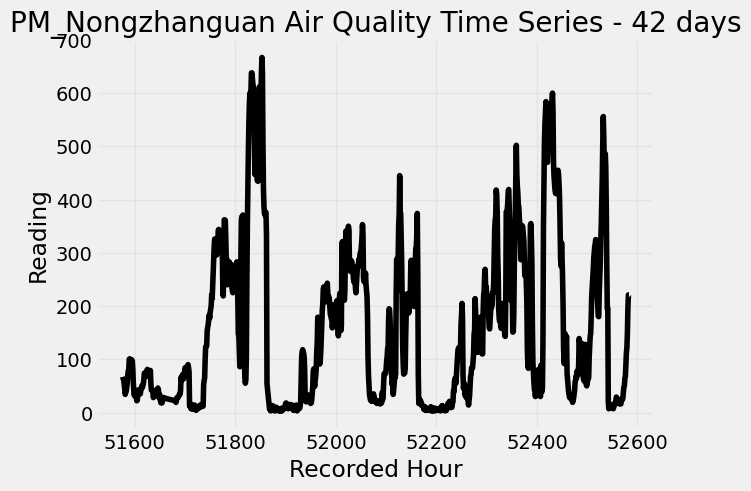

In [135]:
# Check last 6 weeks of data

plot_n_last_days(df_Beijing, 'PM_Nongzhanguan', 42)

In [136]:
series_days = 56
input_hours = 12
test_hours = 24

In [137]:
train_X, test_X, train_y, test_y = (get_train_test_data(df_Beijing,
                                                        'PM_Nongzhanguan',
                                                        series_days,
                                                        input_hours,
                                                        test_hours))

In [138]:
print('Training shape: {}'.format(train_X.shape))

Training shape: (436, 12, 1)


In [139]:
# Train your own model to forecast the "PM_Nongzhaguan"

def supple_SimpleRNN(train_X, train_y, cell_units, epochs):
  model = Sequential()

  model.add(SimpleRNN(cell_units,
                      return_sequences=True,
                      input_shape=(train_X.shape[1],1)))
  model.add(SimpleRNN(cell_units,
                      return_sequences=True))
  model.add(SimpleRNN(cell_units))
  model.add(Dense(1))

  model.compile(loss='mean_squared_error',
                optimizer= 'adam')

  model.fit(train_X, train_y, epochs=epochs, batch_size=32, verbose=0)

  return model

In [140]:
supple_model = supple_SimpleRNN(train_X,
                                train_y,
                                cell_units=10,
                                epochs=20)

1/1 [==============================] - 0s 23ms/step


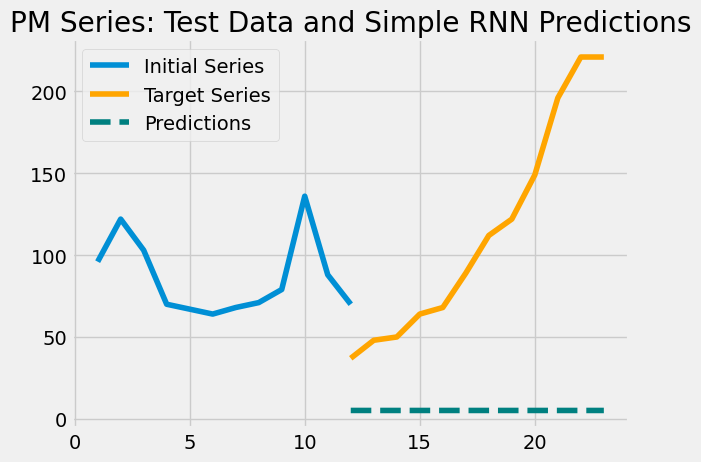

In [141]:
predict_and_plot(test_X_init, test_y, supple_model,
                 'PM Series: Test Data and Simple RNN Predictions')

In [142]:
supple_model = supple_SimpleRNN(train_X,
                                train_y,
                                cell_units=100,
                                epochs=1000)

1/1 [==============================] - 0s 30ms/step


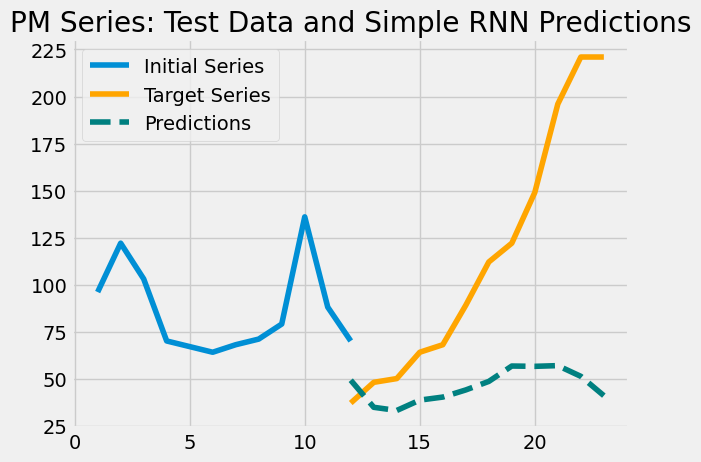

In [143]:
predict_and_plot(test_X_init, test_y, supple_model,
                 'PM Series: Test Data and Simple RNN Predictions')

In [144]:
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 70)                20160     
                                                                 
 dense_19 (Dense)            (None, 1)                 71        
                                                                 
Total params: 20231 (79.03 KB)
Trainable params: 20231 (79.03 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


* Train a LSTM to forecast the PM_Dongsi time series

In [145]:
series_days = 50
input_hours = 12
test_hours = 96

In [146]:
train_X, test_X_init, train_y, test_y = (get_train_test_data(df_Beijing,
                                                             'PM_Dongsi',
                                                             series_days,
                                                             input_hours,
                                                             test_hours))

In [147]:
model = fit_LSTM(train_X, train_y, cell_units=70, epochs=3000)

1/1 [==============================] - 0s 39ms/step


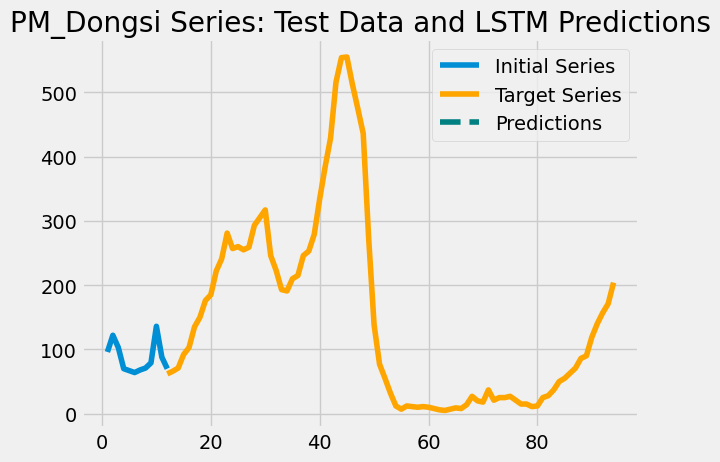

In [148]:
predict_and_plot(test_X_init,
                 test_y, model,
                 'PM_Dongsi Series: Test Data and LSTM Predictions')

## Conclusion

*In conclusion, this activity shows us how the RNN and LSTM models used in time series forecasting. The LSTM tends to perform better than simple RNN for the longer sequences or capturing long-term dependencies.The basic RNN might be sufficient and faster to train. In this activity it shows how the importance of the preprocess the data properly and hypertuning for the better performance.*